
[INTL VAR] Hold-out accuracy
     RMSE: 451.703
      MAE: 350.756
    MAPE%: 8.967
   sMAPE%: 9.688

[DOM  VAR] Hold-out accuracy
     RMSE: 378.425
      MAE: 333.301
    MAPE%: 2.988
   sMAPE%: 3.047

Forecast results saved to: ../output/Model_01_VAR_TECT_AnnualSpend_international.csv
Forecast results saved to: ../output/Model_01_VAR_TECT_AnnualSpend_domestic.csv


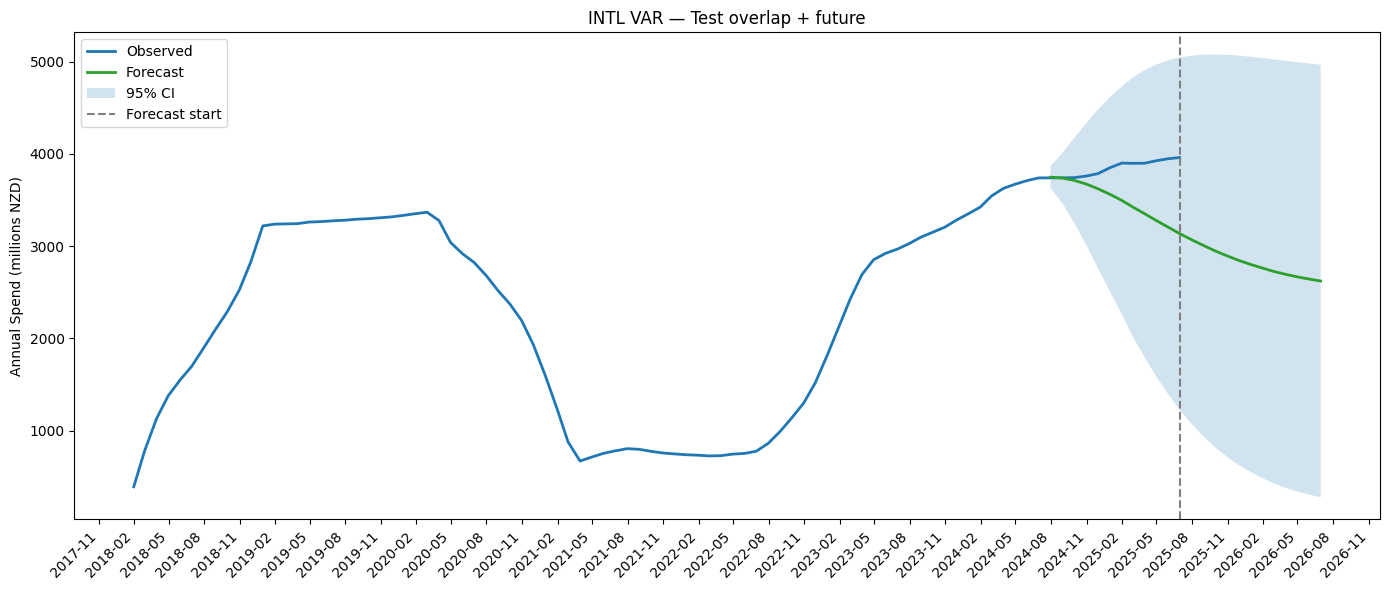

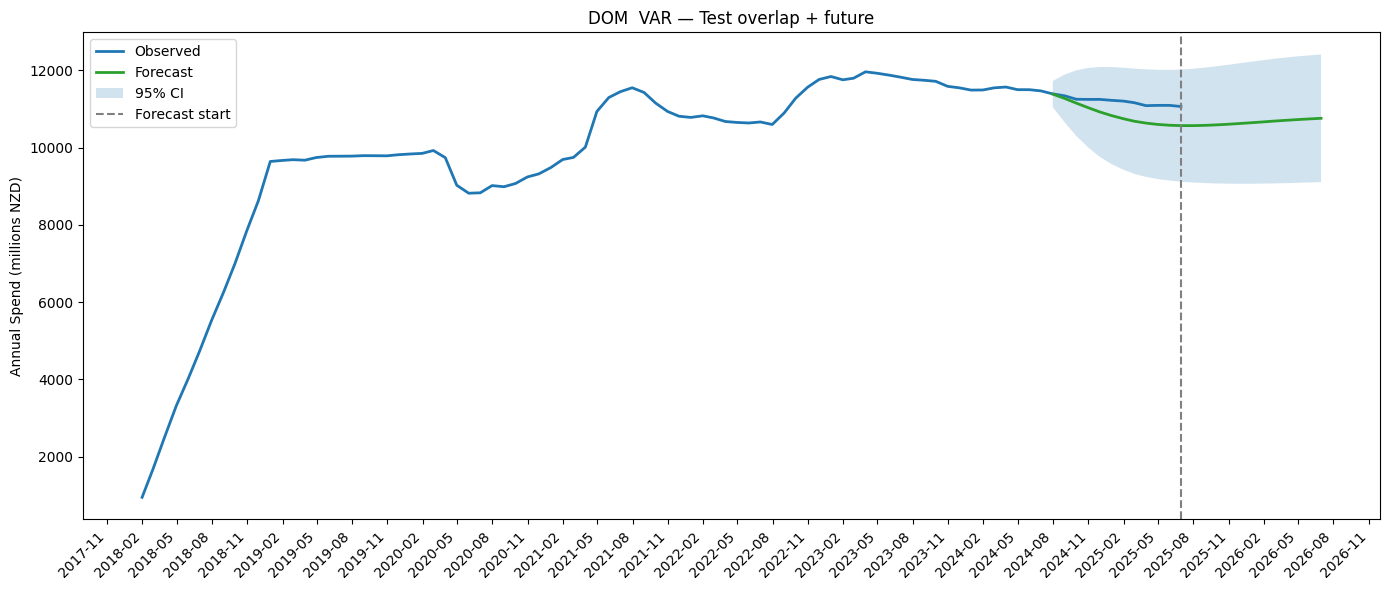

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd

from statsmodels.tsa.api import VAR  # VAR model

# ----------------------- Config -----------------------
TECT_REGION_PATH = "../datasets/TECT/Region-series.csv"
FORECAST_STEPS   = 12   # future horizon (after test)
HOLDOUT_STEPS    = 12   # test window length
MAX_LAGS         = 12   # lag selection upper bound

# ----------------------- Helpers -----------------------
def _end_of_month_index(s: pd.Series) -> pd.DatetimeIndex:
    return pd.to_datetime(s) + MonthEnd(0)

def _full_month_range(idx: pd.Series) -> pd.DatetimeIndex:
    idx_eom = _end_of_month_index(idx)
    return pd.date_range(start=idx_eom.min(), end=idx_eom.max(), freq="M")

def _configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def _metrics(y_true: pd.Series, y_pred: pd.Series) -> dict:
    y_true, y_pred = y_true.astype(float), y_pred.astype(float)
    err  = y_true - y_pred
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(np.mean(np.abs(err)))
    denom = y_true.replace(0, np.nan)
    mape = float(np.mean(np.abs(err) / denom) * 100.0)
    smape = float(100.0 * np.mean(2 * np.abs(err) / (np.abs(y_true) + np.abs(y_pred) + 1e-12)))
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape}

def _print_metrics(title: str, m: dict):
    print(f"\n[{title}] Hold-out accuracy")
    print(f"     RMSE: {m['RMSE']:.3f}")
    print(f"      MAE: {m['MAE']:.3f}")
    print(f"    MAPE%: {m['MAPE%']:.3f}" if np.isfinite(m["MAPE%"]) else "    MAPE%: nan")
    print(f"   sMAPE%: {m['sMAPE%']:.3f}" if np.isfinite(m["sMAPE%"]) else "   sMAPE%: nan")

# ----------------------- Data prep -----------------------
def load_data() -> pd.DataFrame:
    tect = pd.read_csv(TECT_REGION_PATH, parse_dates=["Date"])
    tect["Date"] = tect["Date"] + MonthEnd(0)
    tect = tect.sort_values("Date").rename(
        columns={"Visitor Type": "VisitorType", "Annual Spend": "AnnualSpend", "Monthly Spend": "MonthlySpend"}
    )
    return tect

def build_series(tect: pd.DataFrame):
    all_months = _full_month_range(tect["Date"])

    def _agg(col_vtype: str) -> pd.Series:
        return (
            tect[tect["VisitorType"] == col_vtype]
            .groupby("Date")["AnnualSpend"]
            .sum()
            .reindex(all_months)
            .fillna(0.0)
            .astype("float64")
        )

    intl_y = _agg("International")
    dom_y  = _agg("New Zealand")
    return intl_y, dom_y

# ----------------------- VAR Modeling -----------------------
def evaluate_and_plot_holdout_var(
    intl_y: pd.Series,
    dom_y: pd.Series,
    k_test: int,
    h_future: int
):
    # Prepare combined DataFrame for VAR
    df_all = pd.DataFrame({
        "International": intl_y,
        "Domestic": dom_y
    }).dropna()  # should already be aligned and dense monthly

    if len(df_all) <= k_test + (MAX_LAGS + 12):
        print("[VAR] Skipping hold-out (series too short).")
        return

    df_train = df_all.iloc[:-k_test].copy()
    df_test  = df_all.iloc[-k_test:].copy()

    # Select lag order on training data
    sel = VAR(df_train).select_order(maxlags=MAX_LAGS)
    # Prefer AIC; fall back to the first available if needed
    p = sel.aic
    if p is None or np.isnan(p):
        # fallback: try other criteria
        for crit in [sel.bic, sel.fpe, sel.hqic]:
            if crit is not None and not np.isnan(crit):
                p = crit
                break
    # If still None, default to 1
    lag_order = int(p if p is not None and p > 0 else 1)

    # Fit VAR
    model = VAR(df_train)
    res = model.fit(lag_order, trend="c")

    # Forecast for test + future horizon
    steps_all = k_test + max(h_future, 0)
    # Seed with last lagged observations from train
    y0 = df_train.values[-lag_order:]
    fc_vals = res.forecast(y0, steps=steps_all)                         # (steps_all, k)
    # Try to compute intervals; if not available, fill NaNs
    try:
        fc_mean, fc_lower, fc_upper = res.forecast_interval(y0, steps=steps_all, alpha=0.05)
        # forecast_interval returns (mean, lower, upper), shapes: (steps,k) each
    except Exception:
        fc_mean = fc_vals
        fc_lower = np.full_like(fc_vals, np.nan, dtype="float64")
        fc_upper = np.full_like(fc_vals, np.nan, dtype="float64")

    # Build forecast index (next month after last train)
    start_next = df_train.index[-1] + MonthEnd(1)
    fc_index   = pd.date_range(start=start_next, periods=steps_all, freq="M")

    # Split to test part and future part for metrics
    # Map arrays back to series by column
    col_idx = {name: i for i, name in enumerate(df_all.columns)}
    y_pred_all_intl = pd.Series(fc_mean[:, col_idx["International"]], index=fc_index, name="International")
    y_pred_all_dom  = pd.Series(fc_mean[:, col_idx["Domestic"]],      index=fc_index, name="Domestic")
    ci_lower_intl   = pd.Series(fc_lower[:, col_idx["International"]], index=fc_index)
    ci_upper_intl   = pd.Series(fc_upper[:, col_idx["International"]], index=fc_index)
    ci_lower_dom    = pd.Series(fc_lower[:, col_idx["Domestic"]],      index=fc_index)
    ci_upper_dom    = pd.Series(fc_upper[:, col_idx["Domestic"]],      index=fc_index)

    # Metrics (test window only)
    intl_test_true = df_test["International"]
    dom_test_true  = df_test["Domestic"]
    intl_test_pred = y_pred_all_intl.iloc[:len(intl_test_true)]
    dom_test_pred  = y_pred_all_dom.iloc[:len(dom_test_true)]

    mets_intl = _metrics(intl_test_true, intl_test_pred)
    mets_dom  = _metrics(dom_test_true,  dom_test_pred)

    _print_metrics("INTL VAR", mets_intl)
    _print_metrics("DOM  VAR",  mets_dom)

    # === Save per-series CSVs (append lowercase model_label) ===
    # INTERNATIONAL
    out_csv = "../output/Model_01_VAR_TECT_AnnualSpend"
    out_csv = str(f"{out_csv}_{'International'.lower()}.csv")
    df_out_intl = pd.DataFrame(
        {
            "Observed": intl_y.reindex(fc_index),
            "Forecast": y_pred_all_intl,
            "Lower_CI": ci_lower_intl,
            "Upper_CI": ci_upper_intl,
            "Model": "International",
        }
    )
    df_out_intl.index.name = "Date"
    df_out_intl.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # DOMESTIC
    out_csv = "../output/Model_01_VAR_TECT_AnnualSpend"
    out_csv = str(f"{out_csv}_{'Domestic'.lower()}.csv")
    df_out_dom = pd.DataFrame(
        {
            "Observed": dom_y.reindex(fc_index),
            "Forecast": y_pred_all_dom,
            "Lower_CI": ci_lower_dom,
            "Upper_CI": ci_upper_dom,
            "Model": "Domestic",
        }
    )
    df_out_dom.index.name = "Date"
    df_out_dom.to_csv(out_csv)
    print(f"Forecast results saved to: {out_csv}")

    # INTL
    plt.figure(figsize=(14, 6))
    plt.plot(intl_y.index, intl_y.values, label="Observed", color="tab:blue", linewidth=2)
    plt.plot(y_pred_all_intl.index, y_pred_all_intl.values, label="Forecast", color="tab:green", linewidth=2)
    if not df_out_intl["Lower_CI"].isna().all():
        plt.fill_between(y_pred_all_intl.index, ci_lower_intl.values, ci_upper_intl.values, alpha=0.2, label="95% CI")
    plt.axvline(df_test.index[-1], color="gray", linestyle="--", label="Forecast start")
    plt.title("INTL VAR — Test overlap + future")
    plt.ylabel("Annual Spend (millions NZD)")
    plt.legend()
    _configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

    # DOM
    plt.figure(figsize=(14, 6))
    plt.plot(dom_y.index, dom_y.values, label="Observed", color="tab:blue", linewidth=2)
    plt.plot(y_pred_all_dom.index, y_pred_all_dom.values, label="Forecast", color="tab:green", linewidth=2)
    if not df_out_dom["Lower_CI"].isna().all():
        plt.fill_between(y_pred_all_dom.index, ci_lower_dom.values, ci_upper_dom.values, alpha=0.2, label="95% CI")
    plt.axvline(df_test.index[-1], color="gray", linestyle="--", label="Forecast start")
    plt.title("DOM  VAR — Test overlap + future")
    plt.ylabel("Annual Spend (millions NZD)")
    plt.legend()
    _configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

# ----------------------- Main (VAR) -----------------------
def main_var():
    tect = load_data()
    intl_y, dom_y = build_series(tect)
    evaluate_and_plot_holdout_var(intl_y, dom_y, HOLDOUT_STEPS, FORECAST_STEPS)

if __name__ == "__main__":
    main_var()
